# Political News Data Exploration

This notebook explores the collected political news articles for various ETF tickers across different quarters.

## Overview
- **Tickers**: XLK, XLY, ITA, XLE, XLV, XLF
- **Time Period**: Q1 2024 - Q2 2025
- **Data Source**: GDELT API
- **Purpose**: Analyze political news coverage for Black-Litterman optimization


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('seaborn')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


## 1. Load Data

Load all CSV files from the political_news_data directory.


In [9]:
# Define data directory
data_dir = Path('political_news_data')

# Get all CSV files
csv_files = list(data_dir.glob('*_political_news.csv'))

print(f"Found {len(csv_files)} CSV files")

# Load all data into a list of dataframes
dataframes = []
file_info = []

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        if len(df) > 0:
            # Extract ticker, quarter, and year from filename
            # Format: TICKER_Q{quarter}_{year}_political_news.csv
            parts = csv_file.stem.split('_')
            ticker = parts[0]
            quarter = int(parts[1][1])  # Extract Q1 -> 1
            year = int(parts[2])
            
            df['file_ticker'] = ticker
            df['file_quarter'] = quarter
            df['file_year'] = year
            
            dataframes.append(df)
            file_info.append({
                'file': csv_file.name,
                'ticker': ticker,
                'quarter': quarter,
                'year': year,
                'articles': len(df)
            })
    except Exception as e:
        print(f"Error loading {csv_file.name}: {e}")

# Combine all dataframes
if dataframes:
    all_data = pd.concat(dataframes, ignore_index=True)
    print(f"\nTotal articles loaded: {len(all_data)}")
    # Print the date range based on the actual earliest and latest 'seendate' parsed, if available
    if 'seendate' in all_data.columns and not all_data.empty and all_data['seendate'].notna().any():
        seendates = pd.to_datetime(all_data['seendate'], format='%Y%m%dT%H%M%SZ', errors='coerce')
        min_date = seendates.min()
        max_date = seendates.max()
        if pd.notna(min_date) and pd.notna(max_date):
            print(f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        else:
            print("Date range: could not parse valid seendate values.")
    else:
        print("Date range: date information missing.")

else:
    print("No data files found!")
    all_data = pd.DataFrame()


Found 35 CSV files

Total articles loaded: 4817
Date range: 2024-01-01 to 2025-06-14


## 2. Data Overview

Examine the structure and basic statistics of the dataset.


In [10]:
# Display basic information
print("Dataset Shape:", all_data.shape)
print("\nColumn Names:")
print(all_data.columns.tolist())
print("\nData Types:")
print(all_data.dtypes)
print("\nMissing Values:")
print(all_data.isnull().sum())
print("\nFirst Few Rows:")
all_data.head()


Dataset Shape: (4817, 15)

Column Names:
['url', 'url_mobile', 'title', 'seendate', 'socialimage', 'domain', 'language', 'sourcecountry', 'ticker', 'industry', 'search_keyword', 'article_text', 'file_ticker', 'file_quarter', 'file_year']

Data Types:
url               object
url_mobile        object
title             object
seendate          object
socialimage       object
domain            object
language          object
sourcecountry     object
ticker            object
industry          object
search_keyword    object
article_text      object
file_ticker       object
file_quarter       int64
file_year          int64
dtype: object

Missing Values:
url                  0
url_mobile        3290
title                1
seendate             0
socialimage        736
domain               0
language             0
sourcecountry      198
ticker               0
industry             0
search_keyword       0
article_text         0
file_ticker          0
file_quarter         0
file_year            

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry,ticker,industry,search_keyword,article_text,file_ticker,file_quarter,file_year
0,https://www.capeandislands.org/2025-03-30/how-is-the-tech-industry-thinking-about-ais-environmen...,https://www.capeandislands.org/2025-03-30/how-is-the-tech-industry-thinking-about-ais-environmen...,How is the tech industry thinking about AI environmental impact ?,20250331T003000Z,NaN,capeandislands.org,English,United States,XLK,Technology,tech industry,"How is the tech industry thinking about AI's environmental impact? By Emily Kwong , Avery Keatle...",XLK,1,2025
1,https://www.scmp.com/news/world/united-states-canada/article/3304386/elon-musks-xai-buys-social-...,https://amp.scmp.com/news/world/united-states-canada/article/3304386/elon-musks-xai-buys-social-...,Elon Musk xAI buys social media platform X for US$45 billion,20250328T230000Z,https://cdn.i-scmp.com/sites/default/files/styles/og_image_scmp_generic/public/d8/images/canvas/...,scmp.com,English,China,XLK,Technology,tech sector,Advertisement X (formerly Twitter) World United States & Canada Elon Musk’s xAI buys social medi...,XLK,1,2025
2,https://timesofindia.indiatimes.com/life-style/relationships/work/from-bill-gates-to-elon-musk-5...,https://timesofindia.indiatimes.com/life-style/relationships/work/from-bill-gates-to-elon-musk-5...,From Bill Gates to Elon Musk : 5 common habits of highly successful billionaires,20250328T183000Z,https://static.toiimg.com/photo/119668309.cms,timesofindia.indiatimes.com,English,India,XLK,Technology,tech industry,Sign In TOI News lifestyle relationships work From Bill Gates to Elon Musk: 5 common habits of h...,XLK,1,2025
3,https://www.thecitizen.co.tz/tanzania/oped/shaping-the-future-through-empowering-women-in-tech-4...,NaN,Shaping the future through empowering women in tech,20250328T153000Z,NaN,thecitizen.co.tz,English,Tanzania,XLK,Technology,tech industry,Hawa: Female managers in tech need coaching to thrive,XLK,1,2025
4,https://www.panarmenian.net/eng/news/320846/,NaN,Starlink launches in Armenia with nationwide coverage,20250328T070000Z,NaN,panarmenian.net,English,Armenia,XLK,Technology,tech industry,RSS feeds: RSS (headlines) RSS (articles) RSS (interviews) More RSS feeds PanARMENIAN Photo: RSS...,XLK,1,2025


In [11]:
# Parse dates
if 'seendate' in all_data.columns:
    # Convert seendate from format like "20240607T154500Z" to datetime
    all_data['date'] = pd.to_datetime(all_data['seendate'], format='%Y%m%dT%H%M%SZ', errors='coerce')
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['quarter'] = all_data['date'].dt.quarter
    
    print("Date parsing complete")
    print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")
    print(f"Articles with valid dates: {all_data['date'].notna().sum()} / {len(all_data)}")


Date parsing complete
Date range: 2024-01-01 06:30:00 to 2025-06-14 15:15:00
Articles with valid dates: 4817 / 4817


## 3. Article Counts by Ticker and Quarter


In [12]:
# Article counts by ticker
ticker_counts = all_data.groupby('ticker').size().sort_values(ascending=False)
print("Articles by Ticker:")
print(ticker_counts)
print(f"\nTotal: {ticker_counts.sum()} articles")

# Article counts by ticker and quarter
ticker_quarter_counts = all_data.groupby(['ticker', 'file_year', 'file_quarter']).size().reset_index(name='count')
ticker_quarter_pivot = ticker_quarter_counts.pivot_table(
    index='ticker', 
    columns=['file_year', 'file_quarter'], 
    values='count', 
    fill_value=0
)
print("\nArticles by Ticker, Year, and Quarter:")
print(ticker_quarter_pivot)


Articles by Ticker:
ticker
XLV    1742
XLY    1311
XLK    1107
XLF     257
ITA     219
XLE     181
dtype: int64

Total: 4817 articles

Articles by Ticker, Year, and Quarter:
file_year      2024                        2025       
file_quarter      1      2      3      4      1      2
ticker                                                
ITA            45.0   26.0   35.0   20.0   58.0   35.0
XLE            32.0   15.0   21.0   22.0   57.0   34.0
XLF             7.0   46.0   54.0   48.0   65.0   37.0
XLK           171.0  158.0  184.0  179.0  210.0  205.0
XLV           295.0  272.0  259.0  285.0  334.0  297.0
XLY           255.0  279.0    0.0  274.0  216.0  287.0


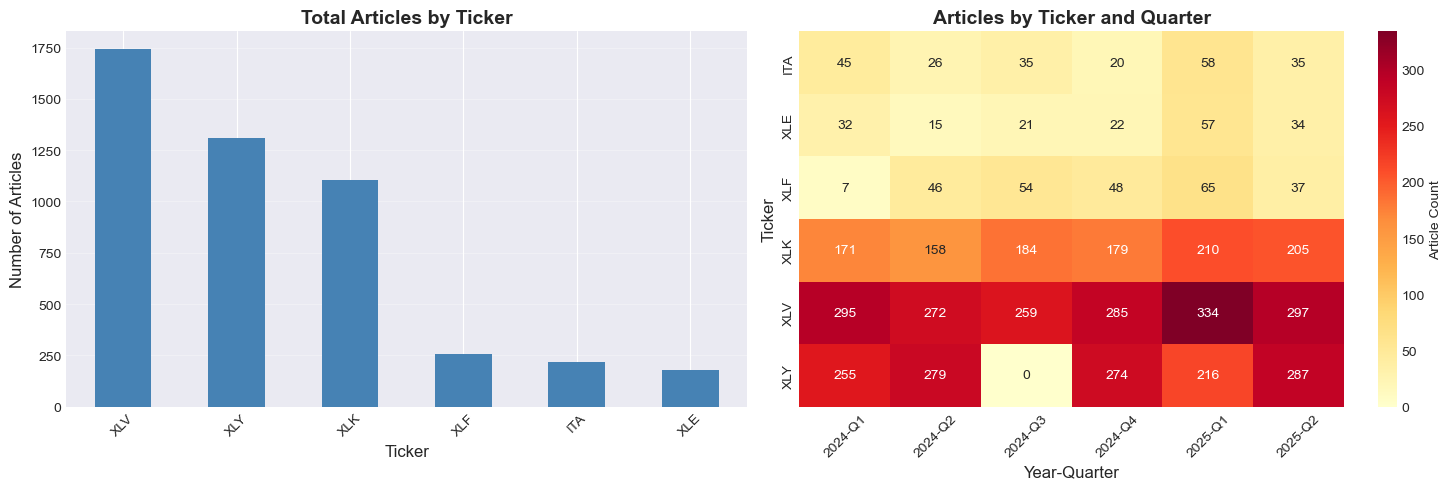

In [15]:
# Visualize article counts by ticker
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart by ticker
ticker_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Total Articles by Ticker', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ticker', fontsize=12)
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Heatmap by ticker and quarter
# Convert pivot table to integers and flatten MultiIndex columns for better display
ticker_quarter_pivot_int = ticker_quarter_pivot.astype(int)
# Flatten MultiIndex columns for better x-axis labels
ticker_quarter_pivot_int.columns = [f"{year}-Q{quarter}" for year, quarter in ticker_quarter_pivot_int.columns]

sns.heatmap(ticker_quarter_pivot_int, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Article Count'})
axes[1].set_title('Articles by Ticker and Quarter', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year-Quarter', fontsize=12)
axes[1].set_ylabel('Ticker', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Time Series Analysis

Analyze article publication trends over time.


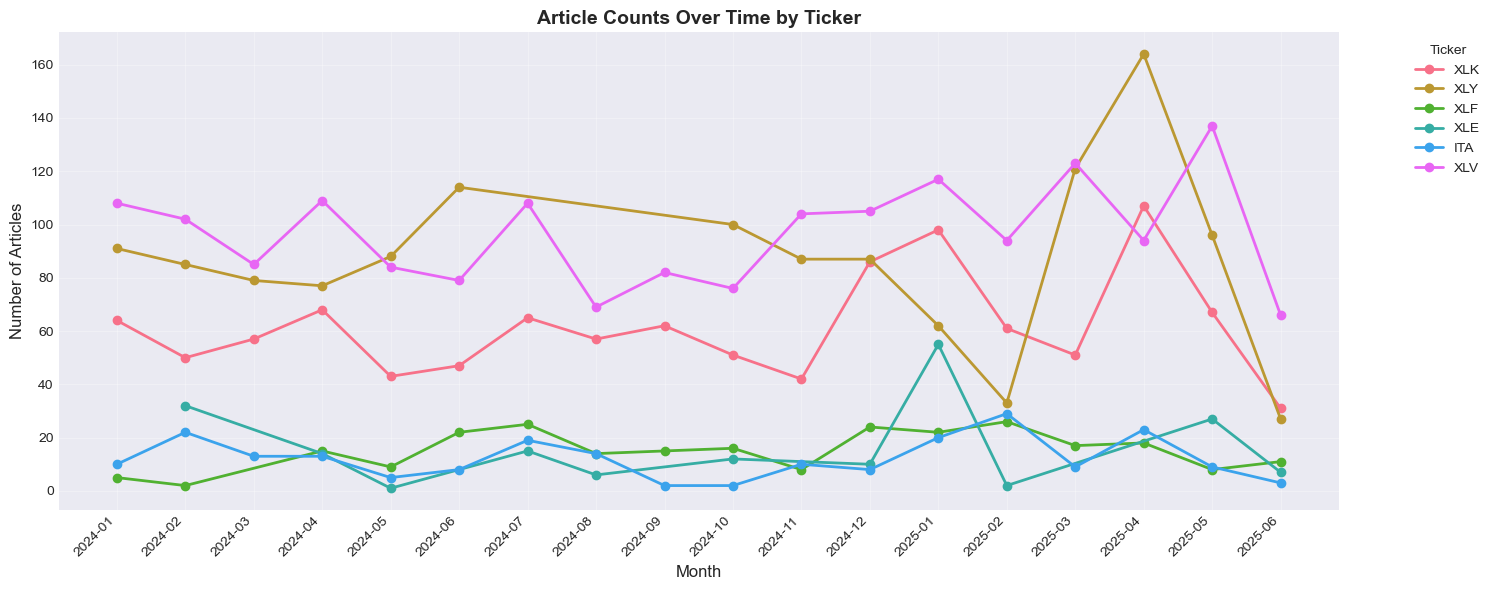

In [16]:
# Time series by month
if 'date' in all_data.columns and all_data['date'].notna().sum() > 0:
    monthly_counts = all_data.groupby([all_data['date'].dt.to_period('M'), 'ticker']).size().reset_index(name='count')
    monthly_counts['date'] = monthly_counts['date'].astype(str)
    
    # Plot time series
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for ticker in all_data['ticker'].unique():
        ticker_data = monthly_counts[monthly_counts['ticker'] == ticker]
        ax.plot(ticker_data['date'], ticker_data['count'], marker='o', label=ticker, linewidth=2)
    
    ax.set_title('Article Counts Over Time by Ticker', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Number of Articles', fontsize=12)
    ax.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Date information not available for time series analysis")


## 5. Source Analysis

Analyze news sources (domains and countries).


In [17]:
# Top domains
if 'domain' in all_data.columns:
    top_domains = all_data['domain'].value_counts().head(15)
    print("Top 15 News Domains:")
    print(top_domains)
    
    # Top domains by ticker
    print("\nTop Domains by Ticker:")
    for ticker in all_data['ticker'].unique():
        ticker_domains = all_data[all_data['ticker'] == ticker]['domain'].value_counts().head(5)
        print(f"\n{ticker}:")
        print(ticker_domains)


Top 15 News Domains:
domain
prnewswire.com                  229
marketscreener.com              194
finance.yahoo.com               178
yahoo.com                       131
economictimes.indiatimes.com    106
finanznachrichten.de            101
menafn.com                       93
forbes.com                       88
globenewswire.com                73
benzinga.com                     66
livemint.com                     59
aninews.in                       58
fool.com                         55
mondaq.com                       49
insidermonkey.com                48
Name: count, dtype: int64

Top Domains by Ticker:

XLK:
domain
finance.yahoo.com               61
marketscreener.com              33
yahoo.com                       24
economictimes.indiatimes.com    24
fool.com                        24
Name: count, dtype: int64

XLY:
domain
marketscreener.com              65
finance.yahoo.com               56
economictimes.indiatimes.com    37
breitbart.com                   36
forexlive.com  

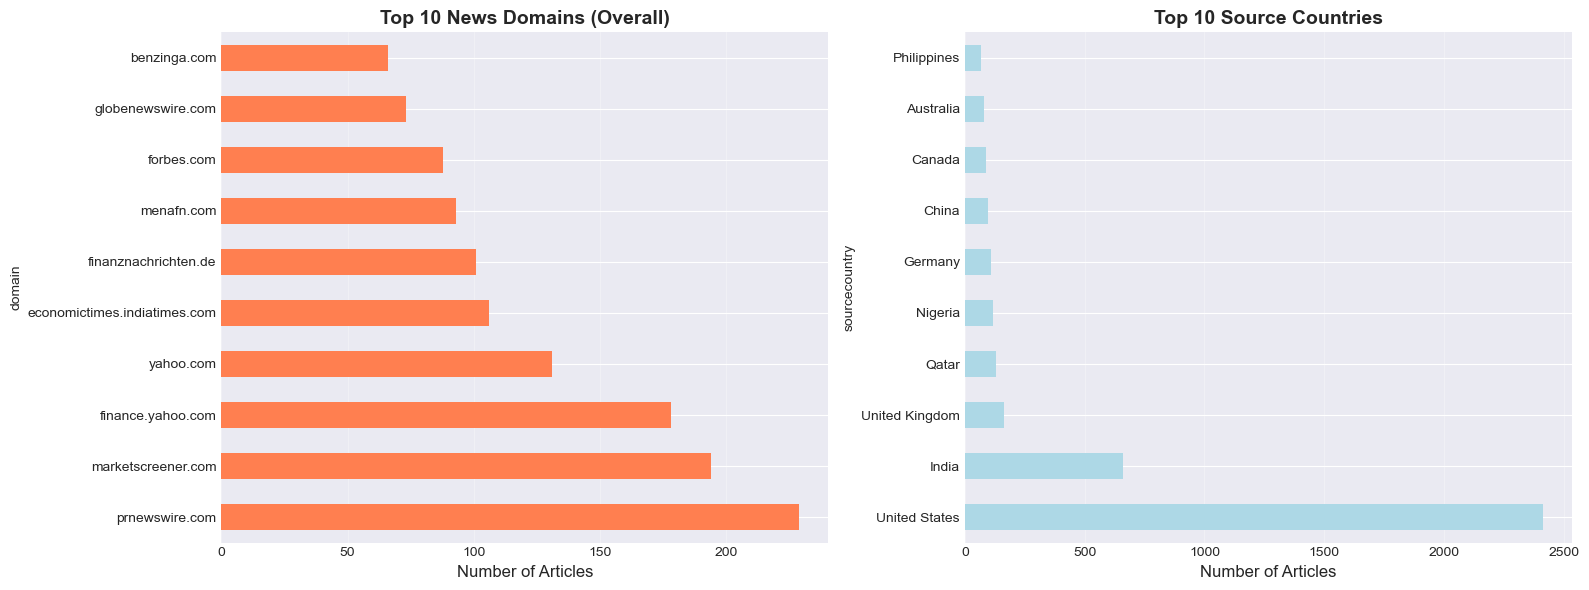

In [18]:
# Visualize top domains
if 'domain' in all_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top domains overall
    top_domains = all_data['domain'].value_counts().head(10)
    top_domains.plot(kind='barh', ax=axes[0], color='coral')
    axes[0].set_title('Top 10 News Domains (Overall)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Articles', fontsize=12)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Source countries
    if 'sourcecountry' in all_data.columns:
        top_countries = all_data['sourcecountry'].value_counts().head(10)
        top_countries.plot(kind='barh', ax=axes[1], color='lightblue')
        axes[1].set_title('Top 10 Source Countries', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Number of Articles', fontsize=12)
        axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 6. Text Analysis

Analyze article text content.


In [19]:
# Article text length analysis
if 'article_text' in all_data.columns:
    all_data['text_length'] = all_data['article_text'].astype(str).str.len()
    all_data['word_count'] = all_data['article_text'].astype(str).str.split().str.len()
    
    print("Article Text Statistics:")
    print(f"Mean length: {all_data['text_length'].mean():.0f} characters")
    print(f"Median length: {all_data['text_length'].median():.0f} characters")
    print(f"Mean word count: {all_data['word_count'].mean():.0f} words")
    print(f"Median word count: {all_data['word_count'].median():.0f} words")
    
    # Text length by ticker
    print("\nText Length by Ticker:")
    text_stats_by_ticker = all_data.groupby('ticker').agg({
        'text_length': ['mean', 'median'],
        'word_count': ['mean', 'median']
    }).round(0)
    print(text_stats_by_ticker)


Article Text Statistics:
Mean length: 4424 characters
Median length: 3914 characters
Mean word count: 678 words
Median word count: 602 words

Text Length by Ticker:
       text_length         word_count       
              mean  median       mean median
ticker                                      
ITA         4181.0  3360.0      634.0  515.0
XLE         5137.0  5030.0      782.0  752.0
XLF         4178.0  3723.0      634.0  550.0
XLK         3811.0  3163.0      609.0  500.0
XLV         5124.0  4566.0      756.0  678.0
XLY         4003.0  3510.0      635.0  563.0


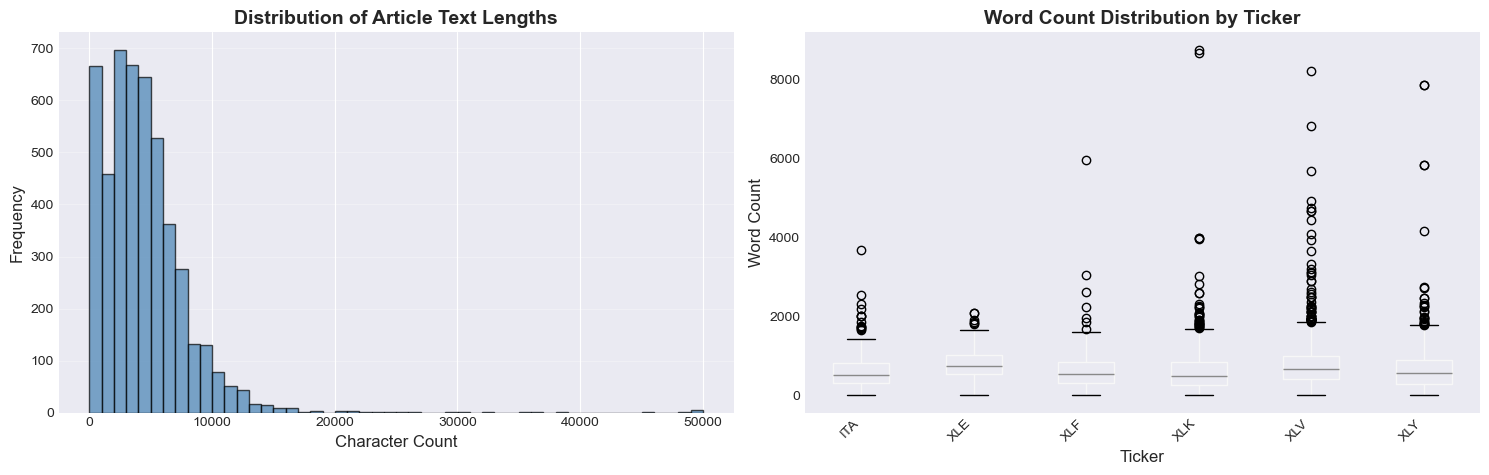

In [20]:
# Visualize text length distributions
if 'article_text' in all_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of text lengths
    axes[0].hist(all_data['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Article Text Lengths', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Character Count', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot by ticker
    ticker_order = all_data.groupby('ticker')['word_count'].median().sort_values(ascending=False).index
    all_data.boxplot(column='word_count', by='ticker', ax=axes[1], grid=False)
    axes[1].set_title('Word Count Distribution by Ticker', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Ticker', fontsize=12)
    axes[1].set_ylabel('Word Count', fontsize=12)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('')  # Remove default title
    plt.tight_layout()
    plt.show()


## 7. Search Keyword Analysis

Analyze which search keywords were most effective.


Search Keyword Effectiveness:
   ticker     search_keyword  count
11    XLV         healthcare   1095
14    XLY  consumer spending    891
8     XLK        tech sector    564
7     XLK      tech industry    530
10    XLV        health care    477
13    XLY   consumer economy    285
6     XLF   financial sector    218
3     XLE             energy    181
12    XLV    pharmaceuticals    170
15    XLY             retail    135
0     ITA          aerospace    122
2     ITA           military     55
1     ITA            defense     42
4     XLF            banking     31
9     XLK         technology     13
5     XLF            finance      8


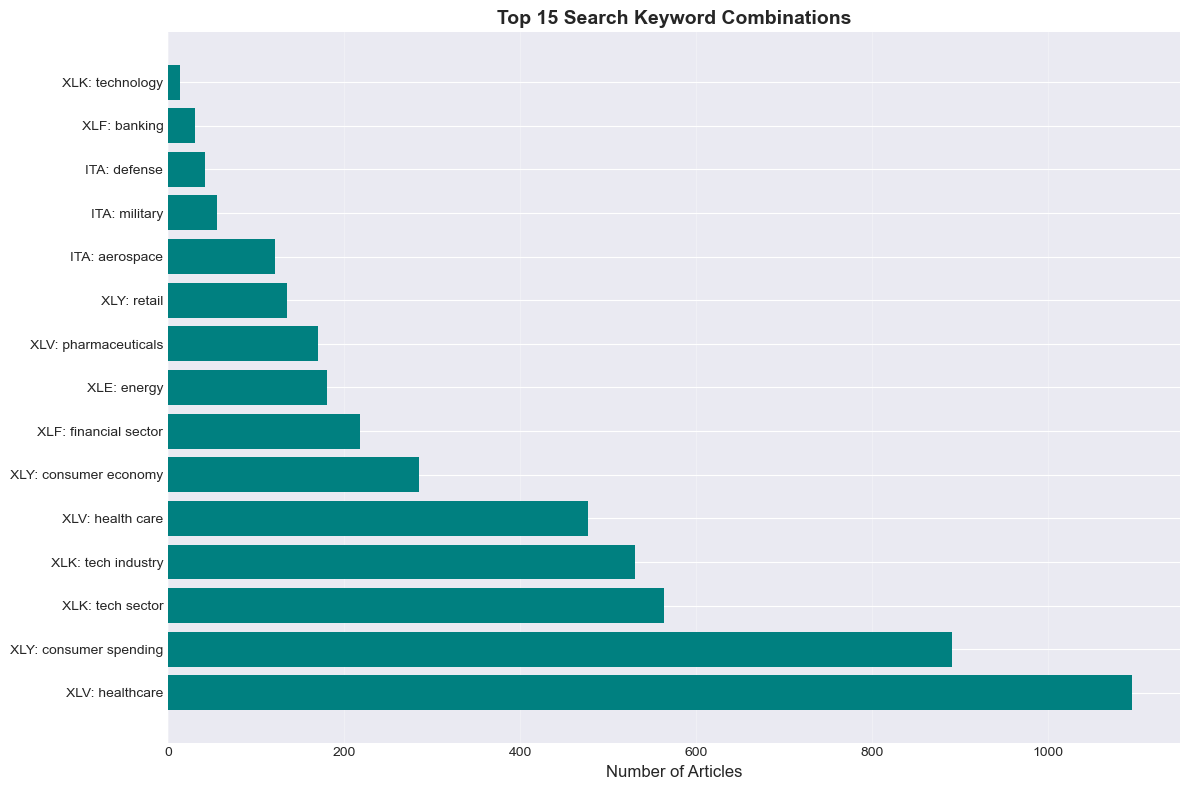

In [21]:
# Search keyword effectiveness
if 'search_keyword' in all_data.columns:
    keyword_counts = all_data.groupby(['ticker', 'search_keyword']).size().reset_index(name='count')
    keyword_counts = keyword_counts.sort_values('count', ascending=False)
    
    print("Search Keyword Effectiveness:")
    print(keyword_counts.head(20))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 8))
    top_keywords = keyword_counts.head(15)
    ax.barh(range(len(top_keywords)), top_keywords['count'], color='teal')
    ax.set_yticks(range(len(top_keywords)))
    ax.set_yticklabels([f"{row['ticker']}: {row['search_keyword']}" for _, row in top_keywords.iterrows()])
    ax.set_xlabel('Number of Articles', fontsize=12)
    ax.set_title('Top 15 Search Keyword Combinations', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 8. Industry Analysis

Compare coverage across different industries.


Articles by Industry:
industry
Healthcare                1742
Consumer Discretionary    1311
Technology                1107
Financial                  257
Aerospace & Defense        219
Energy                     181
dtype: int64


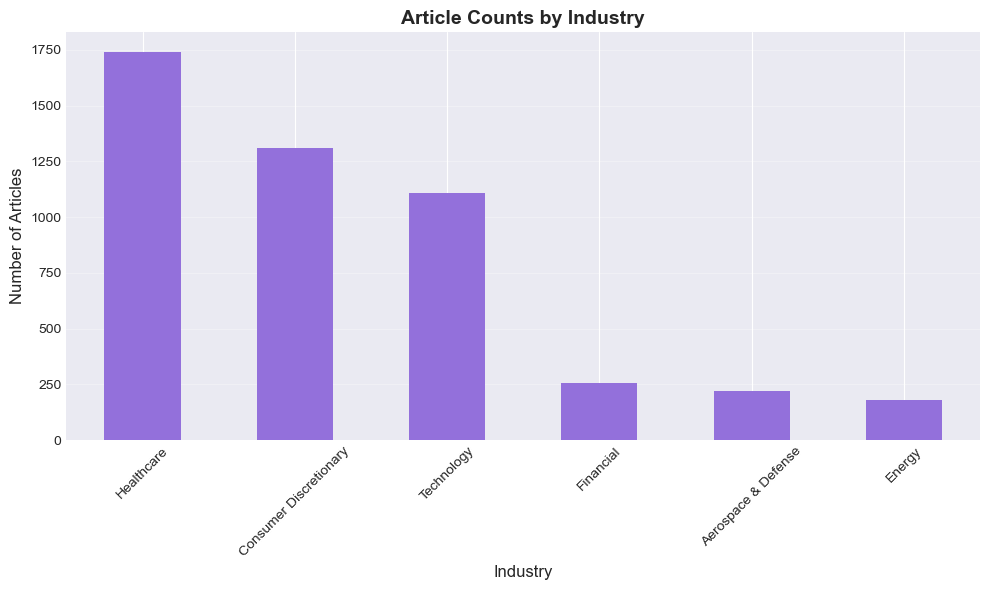

In [22]:
# Industry analysis
if 'industry' in all_data.columns:
    industry_counts = all_data.groupby('industry').size().sort_values(ascending=False)
    
    print("Articles by Industry:")
    print(industry_counts)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    industry_counts.plot(kind='bar', ax=ax, color='mediumpurple')
    ax.set_title('Article Counts by Industry', fontsize=14, fontweight='bold')
    ax.set_xlabel('Industry', fontsize=12)
    ax.set_ylabel('Number of Articles', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


## 9. Summary Statistics

Generate comprehensive summary statistics.


In [23]:
# Create summary statistics table
summary_stats = []

for ticker in sorted(all_data['ticker'].unique()):
    ticker_data = all_data[all_data['ticker'] == ticker]
    
    stats = {
        'Ticker': ticker,
        'Industry': ticker_data['industry'].iloc[0] if 'industry' in ticker_data.columns else 'N/A',
        'Total Articles': len(ticker_data),
        'Unique Domains': ticker_data['domain'].nunique() if 'domain' in ticker_data.columns else 0,
        'Unique Countries': ticker_data['sourcecountry'].nunique() if 'sourcecountry' in ticker_data.columns else 0,
        'Avg Text Length': ticker_data['text_length'].mean() if 'text_length' in ticker_data.columns else 0,
        'Avg Word Count': ticker_data['word_count'].mean() if 'word_count' in ticker_data.columns else 0,
    }
    
    # Add quarter coverage
    quarters = ticker_data.groupby(['file_year', 'file_quarter']).size()
    stats['Quarters Covered'] = len(quarters)
    
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics by Ticker:")
print(summary_df.to_string(index=False))


Summary Statistics by Ticker:
Ticker               Industry  Total Articles  Unique Domains  Unique Countries  Avg Text Length  Avg Word Count  Quarters Covered
   ITA    Aerospace & Defense             219             110                26      4180.730594      634.018265                 6
   XLE                 Energy             181              94                18      5136.933702      782.143646                 6
   XLF              Financial             257             115                34      4178.147860      634.373541                 6
   XLK             Technology            1107             376                41      3811.396567      609.104788                 6
   XLV             Healthcare            1742             382                43      5124.075201      756.359357                 6
   XLY Consumer Discretionary            1311             435                39      4002.604882      634.591152                 5


## 10. Sample Articles

Display sample articles for each ticker.


In [24]:
# Display sample articles
for ticker in sorted(all_data['ticker'].unique()):
    ticker_data = all_data[all_data['ticker'] == ticker]
    if len(ticker_data) > 0:
        sample = ticker_data.iloc[0]
        print(f"\n{'='*80}")
        print(f"Sample Article for {ticker} ({sample.get('industry', 'N/A')})")
        print(f"{'='*80}")
        print(f"Title: {sample.get('title', 'N/A')}")
        print(f"Date: {sample.get('seendate', 'N/A')}")
        print(f"Source: {sample.get('domain', 'N/A')}")
        print(f"Country: {sample.get('sourcecountry', 'N/A')}")
        print(f"Search Keyword: {sample.get('search_keyword', 'N/A')}")
        if 'article_text' in sample and pd.notna(sample['article_text']):
            text_preview = str(sample['article_text'])[:500]
            print(f"\nText Preview:\n{text_preview}...")
        print()



Sample Article for ITA (Aerospace & Defense)
Title: Jim Cramer on GE Aerospace ( GE ):  I Truly Love GE Aerospace Right Here  
Date: 20250606T183000Z
Source: finance.yahoo.com
Country: United States
Search Keyword: aerospace

Text Preview:
Jim Cramer on GE Aerospace (GE): “I Truly Love GE Aerospace Right Here” Syeda Seirut Javed June 5, 2025 2 min read GE We recently published a list of Jim Cramer’s Thoughts on These 12 Stocks . In this article, we are going to take a look at where GE Aerospace (NYSE:GE) stands against other stocks that Jim Cramer discusses. A caller inquired about GE Aerospace (NYSE:GE) during the episode. Cramer replied that he loves the stock here. “GE Aerospace… is about as good as it gets. That guy from June ...


Sample Article for XLE (Energy)
Title: TMEIC India Facilitating the Transition to Renewable Energy Sources
Date: 20240217T144500Z
Source: livemint.com
Country: India
Search Keyword: energy

Text Preview:
View Market Dashboard PARTNERED TMEIC India Facil

## 11. Data Quality Checks

Check for data quality issues.


In [25]:
# Data quality checks
print("Data Quality Report")
print("="*80)

# Missing values
print("\nMissing Values:")
missing = all_data.isnull().sum()
missing_pct = (missing / len(all_data) * 100).round(2)
quality_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(quality_df[quality_df['Missing Count'] > 0])

# Duplicate URLs
if 'url' in all_data.columns:
    duplicates = all_data.duplicated(subset=['url']).sum()
    print(f"\nDuplicate URLs: {duplicates} ({duplicates/len(all_data)*100:.2f}%)")

# Articles with empty text
if 'article_text' in all_data.columns:
    empty_text = (all_data['article_text'].isna() | (all_data['article_text'].astype(str).str.strip() == '')).sum()
    print(f"Articles with empty text: {empty_text} ({empty_text/len(all_data)*100:.2f}%)")

# Articles with valid dates
if 'date' in all_data.columns:
    valid_dates = all_data['date'].notna().sum()
    print(f"Articles with valid dates: {valid_dates} ({valid_dates/len(all_data)*100:.2f}%)")

print("\n" + "="*80)


Data Quality Report

Missing Values:
               Missing Count  Missing %
url_mobile              3290      68.30
title                      1       0.02
socialimage              736      15.28
sourcecountry            198       4.11

Duplicate URLs: 2 (0.04%)
Articles with empty text: 0 (0.00%)
Articles with valid dates: 4817 (100.00%)

